#**Vietnamese Speech Recognition with Wav2Vec**
Nhận diện giọng nói tiếng Việt với Wav2Vec

Đồ án chuyên ngành **Khoa học dữ liệu**

---

**Họ và tên SV 1:** Nguyễn Thành Phát

**MSSV SV 1:** 2000006273

---

**Họ và tên SV 2:** Trần Thị Bé Quyên

**MSSV SV 2:** 2000005977

---


## **Cài đặt thư viện**

In [ ]:
!pip install datasets jiwer transformers torchaudio accelerate==0.21.0

In [ ]:
from datasets import load_dataset, load_metric, Audio
import IPython.display as ipd
import numpy as np
import random
from datasets import ClassLabel
import pandas as pd
from IPython.display import display, HTML

## **Chuẩn bị dữ liệu**

In [ ]:
# Lấy dữ liệu common_voice tiếng Việt
ds_train = load_dataset("mozilla-foundation/common_voice_11_0",
                        "vi", split="train+test")
ds_test = load_dataset("mozilla-foundation/common_voice_11_0",
                       "vi", split="validation")

In [ ]:
ds_test[2]

{'client_id': 'c29d07b14c1806169f49b175b3bc29a620bd2d4c2291a4f8ecbe7dfbaf53fb40f990ebe6617dd1c281d09718ffab9a69d2fb615d19ba084288ba13d134253426',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/e61ff4958c44afed2f006e32a341db137a35fd4138895095d02c755024f468c4/vi_dev_0/common_voice_vi_25222863.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/e61ff4958c44afed2f006e32a341db137a35fd4138895095d02c755024f468c4/vi_dev_0/common_voice_vi_25222863.mp3',
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'sentence': 'Apheng lấy quạt tay choàng nó, nó liền hỏi',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'vi',
 'segment': ''}

In [ ]:
print(ds_train)
print(ds_test)

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 3762
})
Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 248
})


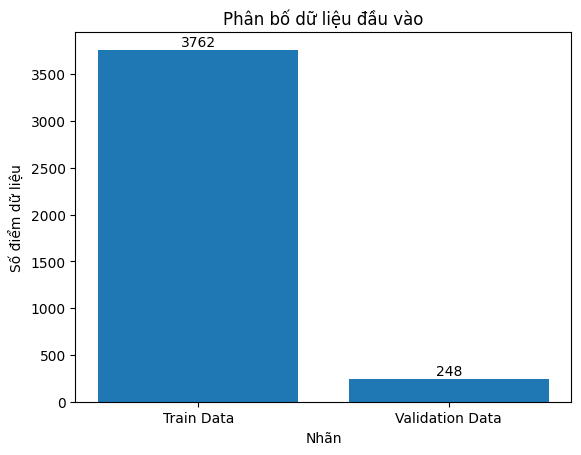

In [ ]:
import matplotlib.pyplot as plt

data = [ds_train.num_rows, ds_test.num_rows]
labels = ['Train Data', 'Validation Data']

plt.bar(labels, data)
for index, value in enumerate(data):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.xlabel('Nhãn')
plt.ylabel('Số điểm dữ liệu')
plt.title('Phân bố dữ liệu đầu vào')
plt.show()

## **Xử lý dữ liệu**

In [ ]:
# Xoá tất cả cột không cần thiết, chỉ giữ lại "sentence", "path", "audio"
ds_train = ds_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
ds_test = ds_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
# Lấy ngẫu nhiên N điểm dữ liệu trong datasets
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Không thể lấy nhiều hơn độ dài dataset"
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(ds_train.remove_columns(["path", "audio"]), num_examples=5)

,sentence
0,Hai quân khốn này
1,Chinh liền hỏi tiếp
2,Khiến cho cả hai đứa giật mình
3,Thất bại là mẹ thành công
4,mẹ còn phải thoa dầu và quấn chăn cho cháu nữa


In [ ]:
# Xoá dấu và các ký tự đặc biệt
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex,
                               '', batch["sentence"]).lower() + " "
    return batch

In [ ]:
ds_train = ds_train.map(remove_special_characters)
ds_test = ds_test.map(remove_special_characters)

In [ ]:
show_random_elements(ds_train.remove_columns(["path","audio"]))

,sentence
0,chinh nghĩ ở trong đầu
1,đời vô tình nghiệt ngã
2,yêu là chết ở trong lòng một ít
3,hay là phóng con thảo là không còn ở đây nữa
4,khiến cho họ thành như vậy còn trách ai
5,không chỉ cầu tiền tài may mắn không đâu
6,chỉ một lát sau bỗng có người chạy tới hớt hải báo tin
7,tôi cũng đi xem mà thầy bảo số trời đã định như thế
8,bye anh
9,tại nhà của chinh lúc này


In [ ]:
# Chuyển Audio về rate 16000
ds_train = ds_train.cast_column("audio", Audio(sampling_rate=16_000))
ds_test = ds_test.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
# Lấy mẫu một điểm dữ liệu
rand_int = random.randint(0, len(ds_train)-1)

print(ds_train[rand_int]["sentence"])
ipd.Audio(data=ds_train[rand_int]["audio"]["array"], autoplay=False, rate=16000)

con thanh nhà mình bị ma quỷ quấy phá 


In [ ]:
print("Target text:", ds_train[rand_int]["sentence"])
print("Input array shape:", ds_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds_train[rand_int]["audio"]["sampling_rate"])

Target text: con thanh nhà mình bị ma quỷ quấy phá 
Input array shape: (97536,)
Sampling rate: 16000


## **Tạo bộ tokenizer**

In [ ]:
# Lấy ra tất cả ký tự có thể tìm được trong dataset
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
# Map hàm trên lên dataset
vocab_train = ds_train.map(
  extract_all_chars, batched=True,
  batch_size=-1, keep_in_memory=True,
  remove_columns=ds_train.column_names
)
vocab_test = ds_test.map(
  extract_all_chars, batched=True,
  batch_size=-1, keep_in_memory=True,
  remove_columns=ds_test.column_names
)

Map:   0%|          | 0/3762 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [ ]:
# Lấy danh sách ký tự trên tập train và test
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
# Xem danh sách ký tự lấy được
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'ạ': 0,
 'g': 1,
 'f': 2,
 'ù': 3,
 'a': 4,
 'w': 5,
 'ớ': 6,
 'ự': 7,
 'ở': 8,
 'ă': 9,
 'ọ': 10,
 'ẽ': 11,
 'ừ': 12,
 'ộ': 13,
 'u': 14,
 'z': 15,
 'ò': 16,
 'ê': 17,
 'ư': 18,
 'à': 19,
 'ể': 20,
 'ỷ': 21,
 'j': 22,
 's': 23,
 'y': 24,
 'v': 25,
 'ũ': 26,
 'ó': 27,
 "'": 28,
 'ơ': 29,
 'ữ': 30,
 'ẫ': 31,
 'ồ': 32,
 'ỏ': 33,
 't': 34,
 'r': 35,
 'ẳ': 36,
 'n': 37,
 'ệ': 38,
 'ễ': 39,
 'ử': 40,
 'e': 41,
 'ặ': 42,
 'ầ': 43,
 'ĩ': 44,
 'i': 45,
 'ỳ': 46,
 'ỉ': 47,
 'ế': 48,
 'q': 49,
 'x': 50,
 'ẩ': 51,
 'm': 52,
 'ề': 53,
 'd': 54,
 'c': 55,
 'ủ': 56,
 'p': 57,
 'ô': 58,
 'ờ': 59,
 'ý': 60,
 'õ': 61,
 'ỵ': 62,
 'ấ': 63,
 'ỗ': 64,
 'b': 65,
 'è': 66,
 'ẻ': 67,
 'ị': 68,
 ' ': 69,
 'ỡ': 70,
 'ú': 71,
 'ổ': 72,
 'ã': 73,
 'ẹ': 74,
 'ố': 75,
 'h': 76,
 'k': 77,
 'á': 78,
 'é': 79,
 'l': 80,
 'ậ': 81,
 'đ': 82,
 'ợ': 83,
 'ỹ': 84,
 'ằ': 85,
 'o': 86,
 'ì': 87,
 'ắ': 88,
 'ẵ': 89,
 'ụ': 90,
 'í': 91,
 'â': 92,
 'ứ': 93,
 'ả': 94}

In [ ]:
# Thay thế khoảng cách bằng dấu phân cách
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
# Thêm [UNK] cho từ không xác định
vocab_dict["[UNK]"] = len(vocab_dict)
# Thêm [PAD] để padding cho cùng chiều dài input
vocab_dict["[PAD]"] = len(vocab_dict)
# In chiều dài từ điển
len(vocab_dict)

97

In [ ]:
# Lưu từ điển thành file json
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
# Login HF để có lưu lại model và tokenizer
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Tên model để load từ HuggingFace
# Model gốc
model_wav2vec2 = "facebook/wav2vec2-large-xlsr-53"
# Đặt tên model mới để finetuning từ model gốc cho Tiếng Việt
model_checkpoint = "phatjk/wav2vec2-vi"

In [ ]:
from transformers import AutoConfig
# Load file config.json từ model gốc
config = AutoConfig.from_pretrained(model_wav2vec2)

tokenizer_type = config.model_type if config.tokenizer_class is None else None
config = config if config.tokenizer_class is not None else None

In [ ]:
# Tạo bộ tokenizer từ vocab.json
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
  "./",
  config=config,
  tokenizer_type=tokenizer_type,
  unk_token="[UNK]",
  pad_token="[PAD]",
  word_delimiter_token="|",
)
# Lưu lại tokenizer Tiếng Việt (làm 1 lần duy nhất)
# tokenizer.push_to_hub(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import Wav2Vec2CTCTokenizer
# Load tokenizer từ hub đã lưu ở trên
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
  model_checkpoint,
  config=config,
  tokenizer_type=tokenizer_type,
  unk_token="[UNK]",
  pad_token="[PAD]",
  word_delimiter_token="|",
)

In [ ]:
tokenizer

Wav2Vec2CTCTokenizer(name_or_path='phatjk/wav2vec2-vi', vocab_size=97, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]', 'additional_special_tokens': [AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True)]}, clean_up_tokenization_spaces=True)

In [ ]:
# Load Extractor
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_wav2vec2)

In [ ]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [ ]:
# Load Wav2Vec2Processor
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
# Hàm map processor lên audio và nhãn của từng điểm dữ liệu trên tập
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"],
                                      sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [ ]:
ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
ds_test = ds_test.map(prepare_dataset, remove_columns=ds_test.column_names)

In [ ]:
# Đặt độ dài tối đa đầu vào là 15s
max_input_length_in_sec = 15.0
ds_train = ds_train.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate,
                           input_columns=["input_length"])
ds_test = ds_test.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate,
                          input_columns=["input_length"])

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Bộ đối chiếu dữ liệu (DataCollator) sẽ tự động pad các đầu vào nhận được.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # thay thế phần pad bằng -100 để bỏ qua loss một cách chính xác
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
# Trình đối chiếu dữ liệu DataCollatorCTCWithPadding
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

#**Tạo hàm tính độ đo WER**

In [ ]:
# Load hàm tính toán chỉ số wer
wer_metric = load_metric("wer")

<ipython-input-37-90fa34a768ae>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [ ]:
# Hàm tính chỉ số wer trên tập validation
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # Không nhóm các tokens (group_tokens) khi tính metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

# **Load mô hình**

In [ ]:
from transformers import AutoModelForCTC
# Tải model wav2vec2 gốc
model = AutoModelForCTC.from_pretrained(
    model_wav2vec2,
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
).to("cuda")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Đóng băng lớp trích xuất đặc trưng để không training lớp này
if hasattr(model, "freeze_feature_extractor"):
  model.freeze_feature_extractor()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1925: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="wav2vec_vietnamese",
  group_by_length=True,
  per_device_train_batch_size=30,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=7,
  gradient_checkpointing=True,
  save_steps=50,
  eval_steps=50,
  logging_steps=50,
  learning_rate=3e-4,
  save_total_limit=2,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
50,7.579600,3.472332,1.000000
100,3.474800,3.437133,1.000000
150,3.456300,3.436660,1.000000
200,3.449500,3.426705,1.000000
250,3.440400,3.504475,1.000000
300,3.416600,3.446950,1.000000
350,3.376400,3.432195,1.000000


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Step,Training Loss,Validation Loss,Wer
50,7.579600,3.472332,1.000000
100,3.474800,3.437133,1.000000
150,3.456300,3.436660,1.000000
200,3.449500,3.426705,1.000000
250,3.440400,3.504475,1.000000
300,3.416600,3.446950,1.000000
350,3.376400,3.432195,1.000000
400,3.346800,3.368752,1.000000


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


TrainOutput(global_step=441, training_loss=3.885882111633716, metrics={'train_runtime': 5269.0842, 'train_samples_per_second': 4.998, 'train_steps_per_second': 0.084, 'total_flos': 3.549038450546166e+18, 'train_loss': 3.885882111633716, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 3.3344216346740723,
 'eval_wer': 1.0,
 'eval_runtime': 21.064,
 'eval_samples_per_second': 11.774,
 'eval_steps_per_second': 1.472,
 'epoch': 7.0}

<function matplotlib.pyplot.show(close=None, block=None)>

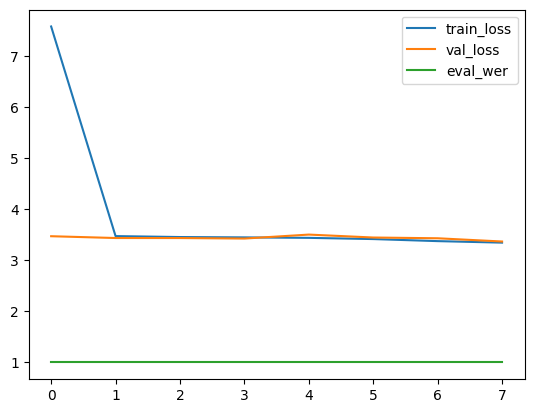

In [ ]:
# Plot biểu đồ đường loss của training và validation
training_loss,validation_loss=[],[]
validation_wer=[]
t = 0
for i in trainer.state.log_history[:-2]:
   if t == 0:
     training_loss.append(i["loss"])
     t=1
   else:
     validation_loss.append(i["eval_loss"])
     validation_wer.append(i["eval_wer"])
     t=0
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.plot(validation_wer,label='eval_wer')
plt.legend()
plt.show

In [ ]:
repo_name = "phatjk/wav2vec2-vi"
model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/phatjk/wav2vec2-vi/commit/819c955a20c398f7dcf5438c87db97e63143aa75', commit_message='Upload Wav2Vec2ForCTC', commit_description='', oid='819c955a20c398f7dcf5438c87db97e63143aa75', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
50,3.335700,3.296169,1.000000
100,3.327400,3.303706,1.000000
150,3.251400,3.131309,1.000000
200,2.891700,2.393150,1.008425
250,2.136400,1.584817,1.018431
300,1.440700,1.180770,0.917325
350,1.089200,1.015057,0.817799
400,0.896000,0.915678,0.784623


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Step,Training Loss,Validation Loss,Wer
50,3.335700,3.296169,1.000000
100,3.327400,3.303706,1.000000
150,3.251400,3.131309,1.000000
200,2.891700,2.393150,1.008425
250,2.136400,1.584817,1.018431
300,1.440700,1.180770,0.917325
350,1.089200,1.015057,0.817799
400,0.896000,0.915678,0.784623


TrainOutput(global_step=441, training_loss=2.1615884655457234, metrics={'train_runtime': 5308.6492, 'train_samples_per_second': 4.961, 'train_steps_per_second': 0.083, 'total_flos': 3.551949127093889e+18, 'train_loss': 2.1615884655457234, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.889062225818634,
 'eval_wer': 0.770405476566614,
 'eval_runtime': 21.7224,
 'eval_samples_per_second': 11.417,
 'eval_steps_per_second': 1.427,
 'epoch': 7.0}

<function matplotlib.pyplot.show(close=None, block=None)>

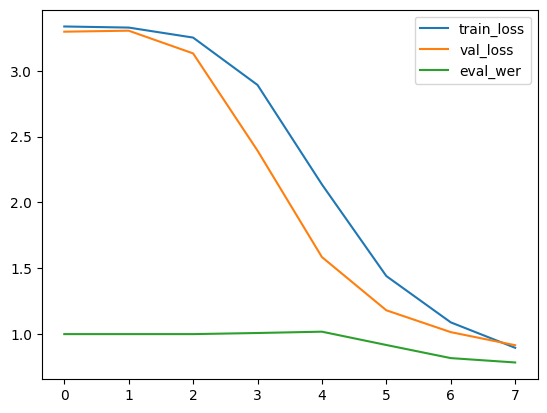

In [ ]:
# Plot biểu đồ đường loss của training và validation
training_loss,validation_loss=[],[]
validation_wer=[]
t = 0
for i in trainer.state.log_history[:-3]:
   if t == 0:
     training_loss.append(i["loss"])
     t=1
   else:
     validation_loss.append(i["eval_loss"])
     validation_wer.append(i["eval_wer"])
     t=0
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.plot(validation_wer,label='eval_wer')
plt.legend()
plt.show

In [ ]:
repo_name = "phatjk/wav2vec2-vi"
model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/phatjk/wav2vec2-vi/commit/b9292570ae156a4df7a19bafef7034fdb92c30ff', commit_message='Upload Wav2Vec2ForCTC', commit_description='', oid='b9292570ae156a4df7a19bafef7034fdb92c30ff', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
50,0.818100,0.802609,0.709847
100,0.669600,0.825520,0.704055
150,0.568400,0.706859,0.640337


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Step,Training Loss,Validation Loss,Wer
50,0.818100,0.802609,0.709847
100,0.669600,0.825520,0.704055
150,0.568400,0.706859,0.640337
200,0.504400,0.673142,0.630332
250,0.477400,0.647326,0.582938
300,0.393600,0.627329,0.588204
350,0.360300,0.598263,0.566087
400,0.332800,0.603821,0.562928


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

TrainOutput(global_step=441, training_loss=0.4996468572119196, metrics={'train_runtime': 5286.6358, 'train_samples_per_second': 4.981, 'train_steps_per_second': 0.083, 'total_flos': 3.5523796728548413e+18, 'train_loss': 0.4996468572119196, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6021169424057007,
 'eval_wer': 0.5555555555555556,
 'eval_runtime': 21.8445,
 'eval_samples_per_second': 11.353,
 'eval_steps_per_second': 1.419,
 'epoch': 7.0}

In [ ]:
repo_name = "phatjk/wav2vec2-vi"
model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/phatjk/wav2vec2-vi/commit/e3c04a1f37f00ed9ec90164194a497d6209b97b3', commit_message='Upload Wav2Vec2ForCTC', commit_description='', oid='e3c04a1f37f00ed9ec90164194a497d6209b97b3', pr_url=None, pr_revision=None, pr_num=None)

<function matplotlib.pyplot.show(close=None, block=None)>

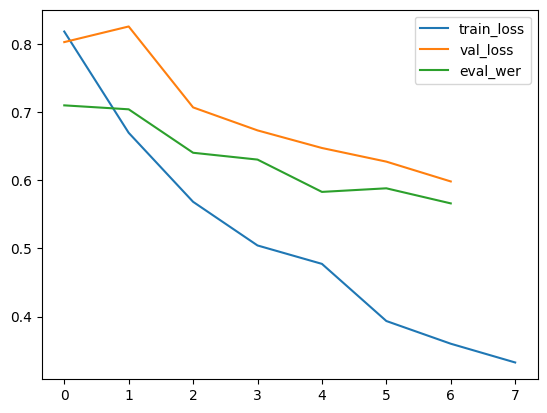

In [ ]:
# Plot biểu đồ đường loss của training và validation
training_loss,validation_loss=[],[]
validation_wer=[]
t = 0
for i in trainer.state.log_history[:-3]:
   if t == 0:
     training_loss.append(i["loss"])
     t=1
   else:
     validation_loss.append(i["eval_loss"])
     validation_wer.append(i["eval_wer"])
     t=0
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.plot(validation_wer,label='eval_wer')
plt.legend()
plt.show

In [ ]:
# Chọn một audio ngẫu nhiên để test thử
import IPython.display as ipd
import numpy as np
import random
audio_num = random.randint(0, ds_test.num_rows)
ipd.Audio(data=ds_test[audio_num]["input_values"], autoplay=False, rate=16000)

In [ ]:
# Kết quả dự đoán
from transformers import AutoModelForCTC

inputs = processor(ds_test[audio_num]["input_values"], sampling_rate=16000, return_tensors="pt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)
with torch.no_grad():
    logits = model(**inputs).logits
    # Ket qua du doan
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    print("Result: ",transcription)

Result:  ['nó húc văng cả người cả sê']
